# Exercise 02: SVD/PCA on MNIST Digits

In this exercise,
you'll explore the use of Singular Value Decomposition (SVD)
to perform Principle Component Analysis (PCA)
on the MNIST handwritten digits dataset.

As usual, let's start by installing the needed packages:

In [1]:
import sys
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U scikit-learn matplotlib

Now let's load the MNIST dataset:

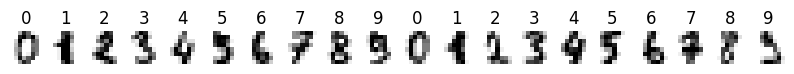

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
dataset = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
for ax, image, label in zip(axes, dataset.images, dataset.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

We have 1797 examples of 8x8 pixel images:

In [3]:
dataset.images.shape

(1797, 8, 8)

**How many dimensions does each image have?**

(Hint #1: The answer isn't 2.)

(Hint #2: How many numbers does it take to represent one image?)

These are 8 x 8 images, so we need 64 dimensions for the images.

We're going to "flatten" the 8x8 pixel images into 64 pixel vectors to aid our processing.
Note the transpose (`.T`); each image vector is now a column vector.

In [4]:
N_samples = len(dataset.images)
data = dataset.images.reshape((N_samples, 64)).T
data.shape

(64, 1797)

Let's take a compare the tranpose of the first data vector
(displayed as a row instead of a column)
to the first 8x8 dataset image.
Make sure you understand what you're looking at!

In [5]:
print('data[:,0]=\n{}'.format(data[:,0]))
print('dataset.images[0]=\n{}'.format(dataset.images[0]))

data[:,0]=
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
dataset.images[0]=
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


**Why do we need to normalize our data before performing SVD?**

If our data is not centered it will throw off our axis.

Let's go ahead and normalize.  We need to keep the mean and stddev info for later use.

In [6]:
data_mean = np.mean(data, axis=1).reshape((64,1))
#print('data_mean = \n{}'.format(data_mean))

data_stddev = np.std(data, axis=1).reshape((64,1))
data_stddev[data_stddev == 0] = 0.001
#print('data_stddev = \n{}'.format(data_stddev))

data_normalized = (data - data_mean)/data_stddev

Inspect the following code and its output:

In [7]:
print(np.mean(data_normalized, axis=1))
print(np.std(data_normalized, axis=1))

[ 0.00000000e+00 -2.56086502e-16 -2.34771702e-16 -3.05326777e-16
  1.39689163e-16 -3.16941798e-16 -9.59598443e-16  6.06946633e-16
 -4.62368967e-16  7.55084971e-17 -5.33796713e-17  5.71483749e-17
  4.52862258e-17 -1.49512505e-17  8.96580775e-16 -2.17719863e-16
 -6.87973761e-16 -7.70421876e-17  2.59978769e-16  2.32547550e-16
  1.05878949e-16 -1.40863021e-16 -1.15408826e-16 -2.26477465e-16
  4.51109193e-16  3.79341646e-17 -7.71657517e-17 -9.60092699e-17
 -8.72980041e-17 -1.50624582e-16 -1.05597840e-15 -2.52140175e-16
  0.00000000e+00  3.42148865e-16  1.21710593e-16 -1.07871419e-16
 -2.00606242e-16 -1.09354188e-17 -7.12964591e-17  0.00000000e+00
  3.00716294e-16 -1.74657790e-16  4.03436636e-16  1.92111213e-16
  2.61337974e-17  5.38739275e-17  4.71396866e-17  8.63759074e-16
  2.62048467e-16  3.33128689e-16  8.36528645e-17  1.98775949e-16
  4.61017485e-16  5.01670059e-17  4.71582212e-16 -4.92032063e-16
  2.25353805e-16  3.44125890e-16  5.95269830e-17 -6.11460582e-16
 -5.19092591e-16  1.69529

**Do these values make sense?  Why or why not?  Do you see anything unexpected?**

We would expect the mean to be at the origin, 0, but instead we get a host of negative values. These seem very close to zero though- so maybe its ok. The standard deviation seems ok, but there are a lot of 0s when I'd expect to see just ones.

Now that we have normalized data,
we can construct the covariance matrix.

**What shape do you expect the covariance matrix to have?  Why?**

I would expect the covariance matrix to be a 64 x 64 because that is the number of dimensions we have.

In [8]:
C = np.dot(data_normalized,data_normalized.T)
C.shape

(64, 64)

Before you run the code below,
stop and think about what we're doing:
we want to reduce the dimensionality of the MNIST dataset
to something more "manageable".

**What is the minimum number of dimensions we can reasonably expect for this dataset?  Why?**

I would expect 64 because I would expect to have a dimension for each pixel. If there was a pixel we do not need, maybe one in the corner(?) we could reduce the number of expected dimensions. Ex. if we dont need the corner pixels, we could get away with 60. (they could always be white or otherwise superfluous.

Let's perform SVD on the covariance matrix,
and inspect the diagonal, `S`, of the singular value matrix:

S = 
[1.31912178e+04 1.04805410e+04 9.25651427e+03 7.12335980e+03
 5.32755597e+03 4.61939178e+03 4.32119291e+03 3.71533769e+03
 3.28655993e+03 3.21397324e+03 3.04933169e+03 2.82489048e+03
 2.49411924e+03 2.44136762e+03 2.37345955e+03 2.09825201e+03
 1.94630145e+03 1.79560240e+03 1.74999174e+03 1.63240670e+03
 1.47760380e+03 1.39425301e+03 1.27795593e+03 1.15936047e+03
 1.06911208e+03 1.03539723e+03 9.46009867e+02 9.17102797e+02
 8.74407408e+02 8.18259523e+02 7.95361387e+02 7.58452350e+02
 7.16794919e+02 7.02417596e+02 6.48257522e+02 6.26091094e+02
 5.73994955e+02 5.28143022e+02 4.97353441e+02 4.63858315e+02
 4.45103194e+02 4.35272454e+02 3.90777264e+02 3.73560685e+02
 3.59363259e+02 3.40943955e+02 3.16327580e+02 3.03079236e+02
 2.84099795e+02 2.57033236e+02 2.39246620e+02 2.23177619e+02
 2.14314856e+02 2.00948239e+02 1.84097792e+02 1.76742134e+02
 1.61973032e+02 1.48112749e+02 1.37131681e+02 1.13668149e+02
 9.04724945e+01 9.83226354e-13 9.83226354e-13 9.83226354e-13]


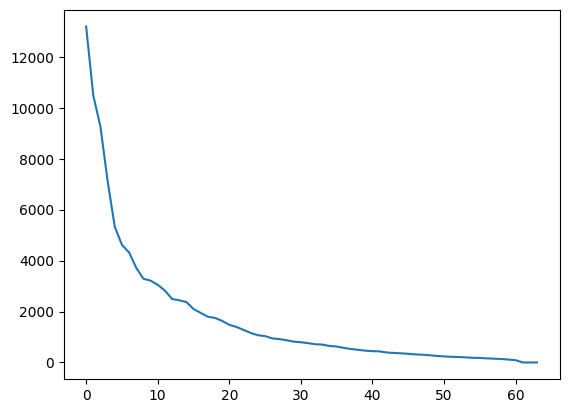

In [9]:
U,S,Vh = np.linalg.svd(C)
print('S = \n{}'.format(S))
plt.plot(S)
plt.show();

**Based on the values and scree plot above, how many meaningful dimensions does this MNIST data have?  How did you come to that conclusion?**

10-15sh seems like a reasonable range. The vast majority of the data is within those dimensions.

**Based on the values and scree plot above, how many dimensions can we *definitely* get rid of?**

We can definitely get rid of anything above 40. 

**What do the dimensions we can eliminate say about the input data values?**

The input data values must be numbers that do not utilize those pixels.

Below I've "inverted" the scree plot
to show the percentage of information retained
versus number of dimensions retained.

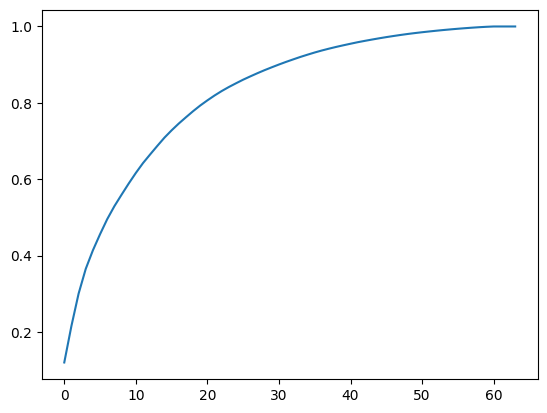

In [14]:
plt.plot(np.cumsum(S)/np.sum(S))
plt.show()

Let's retain only 5 dimensions and take a look at the results.

First, we'll project our data onto the best 5D approximation of our covariance matrix:

In [15]:
ND = 5

P = np.dot(np.diagflat(S[0:ND]), Vh[0:ND,:])
compressed_data = np.dot(P,data_normalized)
compressed_data.shape

(5, 1797)

**Explain the shape of `compressed_data` shown above.**

5 is the number of dimensions, with 1797 being the number of data samples.

Our `compressed_data` currently lives in a 5D space with the basis determined by SVD.
We'd like to bring it back into our original image space and coordinate system.

Unfortunately, the matrix `P` is singular, so we can't invert it.
Instead, we'll use the "pseudo-inverse" as the next best thing:

In [16]:
UnP = np.linalg.pinv(P)
UnP.shape

(64, 5)

Now we'll use our "unpack" (`UnP`) matrix to bring our `compressed_data` back into the original input space.

Note that we need to undo the data normalization, because that wasn't accounted for by the SVD process.

In [18]:
unpacked_data = np.dot(UnP,compressed_data)*data_stddev + data_mean
unpacked_images = np.reshape(unpacked_data.T, (N_samples, 8, 8))
unpacked_images.shape

(1797, 8, 8)

Let's see how well 5 dimensions representated our data.

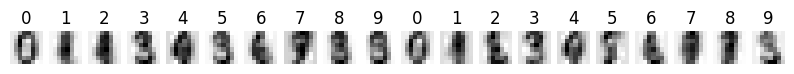

In [19]:
_, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
for ax, image, label in zip(axes, unpacked_images, dataset.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

**What are your thoughts on these images?  Are 5 dimensions enough?  Why do some numbers appear reasonably clear while others are garbled?**

The number of dimensions needed depends greatly on the numbers we are needing to tell apart. Some of them, like 3, are more distinct that others. 4 and 9 could easily be confused if we do not have enoughpixels to clearly see the difference in their shape.

Take a look at the first unpacked image values versus the original image values:

In [20]:
print('unpacked_images[0] =\n{}'.format(unpacked_images[0]))
print('dataset.images[0] = \n{}'.format(dataset.images[0]))

unpacked_images[0] =
[[-1.55194165e-19  1.97392904e-01  4.92301023e+00  1.22029804e+01
   1.27113042e+01  6.42071202e+00  1.50387052e+00  1.42352030e-01]
 [ 1.12160141e-03  1.84466751e+00  1.37315597e+01  1.13614650e+01
   7.43223111e+00  9.79719750e+00  2.22722810e+00  1.78567689e-01]
 [ 1.75079376e-03  4.43674263e+00  1.58683671e+01  2.82204343e+00
  -2.79853950e-01  1.00758063e+01  4.11641135e+00  1.15611160e-01]
 [ 1.03533860e-03  5.94830558e+00  1.51447913e+01  3.77790690e+00
   2.85352348e+00  1.13139090e+01  6.27220699e+00  7.86836483e-03]
 [ 0.00000000e+00  6.10506997e+00  1.14771439e+01  2.47900450e+00
   2.63989472e+00  1.35106141e+01  7.28597256e+00  0.00000000e+00]
 [ 3.12735336e-02  3.76240037e+00  9.86837147e+00  1.02203084e+00
   1.64412964e+00  1.31218491e+01  6.60175465e+00 -3.36505294e-02]
 [ 2.97590371e-02  1.19543696e+00  9.93991053e+00  6.26414666e+00
   7.76098005e+00  1.18165342e+01  2.41974816e+00 -5.03054929e-01]
 [ 1.50317767e-04  1.90996652e-01  5.21882992e+0

Let's try the same steps again, but this time we'll retain all 64 dimensions.

In [21]:
ND = 64

P = np.dot(np.diagflat(S[0:ND]), Vh[0:ND,:])
compressed_data = np.dot(P,data_normalized)
compressed_data.shape

(64, 1797)

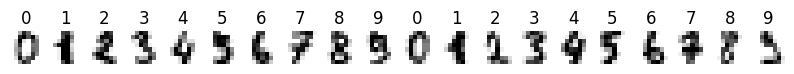

In [23]:
UnP = np.linalg.pinv(P)

unpacked_data = np.dot(UnP,compressed_data)*data_stddev + data_mean
unpacked_images = np.reshape(unpacked_data.T, (N_samples, 8, 8))

_, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
for ax, image, label in zip(axes, unpacked_images, dataset.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

For comparison, let's look at the original dataset images.

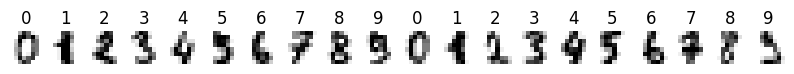

In [24]:
_, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
for ax, image, label in zip(axes, dataset.images, dataset.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("%i" % label)

**What do you notice?  Why is that the case?**

These are identical, I would guess because they have the same number of dimensions.

Let's compare the unpacked/original image values again:

In [25]:
print('unpacked_images[0] =\n{}'.format(unpacked_images[0]))
print('dataset.images[0] = \n{}'.format(dataset.images[0]))

unpacked_images[0] =
[[ 0.00000000e+00 -2.17603713e-14  5.00000000e+00  1.30000000e+01
   9.00000000e+00  1.00000000e+00 -2.22044605e-15  6.21724894e-15]
 [-6.07153217e-18  4.79616347e-14  1.30000000e+01  1.50000000e+01
   1.00000000e+01  1.50000000e+01  5.00000000e+00  1.12410081e-15]
 [-1.23599048e-16  3.00000000e+00  1.50000000e+01  2.00000000e+00
  -1.24344979e-14  1.10000000e+01  8.00000000e+00 -2.28983499e-16]
 [-3.29597460e-17  4.00000000e+00  1.20000000e+01  1.06581410e-14
  -1.95399252e-14  8.00000000e+00  8.00000000e+00 -1.08420217e-16]
 [-1.34623609e-19  5.00000000e+00  8.00000000e+00 -3.55271368e-15
   3.55271368e-15  9.00000000e+00  8.00000000e+00 -1.75535635e-20]
 [ 2.94902991e-16  4.00000000e+00  1.10000000e+01 -2.13162821e-14
   1.00000000e+00  1.20000000e+01  7.00000000e+00 -4.33680869e-16]
 [ 1.76941795e-16  2.00000000e+00  1.40000000e+01  5.00000000e+00
   1.00000000e+01  1.20000000e+01 -1.24344979e-14  3.05311332e-16]
 [-1.69135539e-17  2.04281037e-14  6.00000000e+0

**How well did 64 dimensions approximate our original dataset?  Why?**

64 dimensions did an excellent job, as it had the same number of dimensions and did not lose any information.

It would seem that there is some middle ground between 5D and 64D that would serve our purpose.  Let's try to find it. 

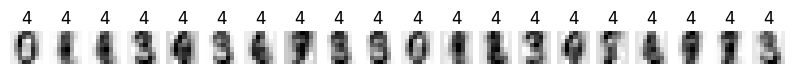

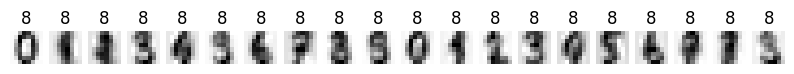

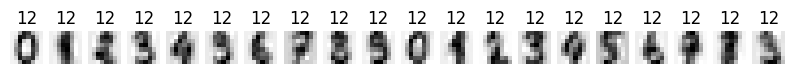

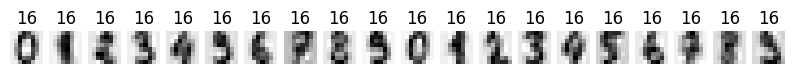

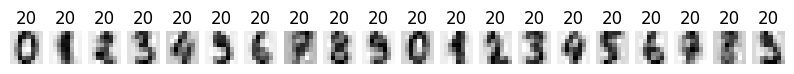

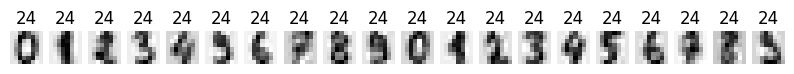

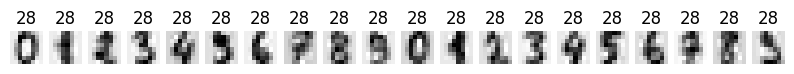

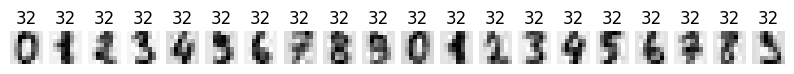

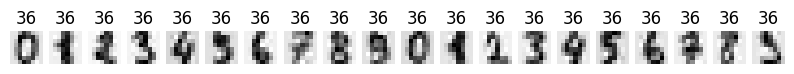

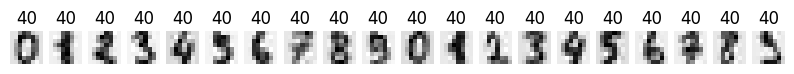

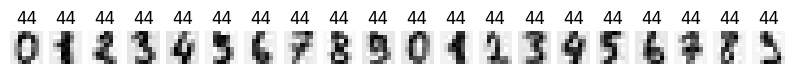

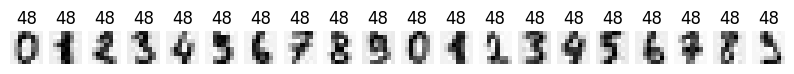

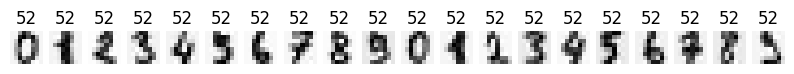

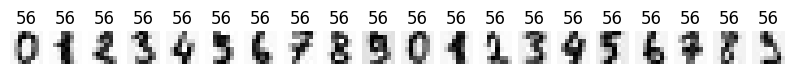

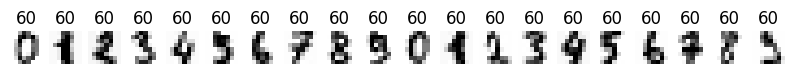

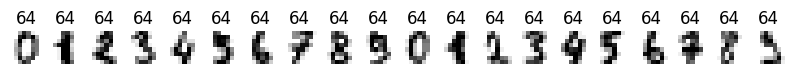

In [27]:
for ND in range(4,65,4):    
    P = np.dot(np.diagflat(S[0:ND]), Vh[0:ND,:])
    compressed_data = np.dot(P,data_normalized)
    UnP = np.linalg.pinv(P)

    unpacked_data = np.dot(UnP,compressed_data)*data_stddev + data_mean
    unpacked_images = np.reshape(unpacked_data.T, (N_samples, 8, 8))

    _, axes = plt.subplots(nrows=1, ncols=20, figsize=(10, 3))
    for ax, image, label in zip(axes, unpacked_images, dataset.target):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("%i" % ND)

**Based on the above plots, how many dimensions would you retain?  How did you come to that conclusion?**

12-16 seems like a good number of dimensions. I came to that conclusion by focusing on the problem numbers like 1 and 4. If I could reliably tell them apart, I felt good about them.

**What did you think of this exercise?**

I really liked seeing the visual representations of the effects of having more or less dimensions.